# A look at Internal Rate of Return

This notebook aims to look at the internal rate of return *(IRR)* calculation
from a `pythonic` perspective as well as the broader financial meanings.

For formal definitions, feel free to read the wikipedia page:
https://en.wikipedia.org/wiki/Internal_rate_of_return

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

## Table of Contents

* [A look at Numpy IRR](#A-look-at-Numpy-IRR)
    * [Numpy root finding](#Numpy-root-finding)
* [The Financial Perspective](#The-Financial-Perspective)
* [A look at Scipy](#A-look-at-Scipy)
    * [Fsolve](#Fsolve)
* [Optimising Using Numba](#Optimising-Using-Numba)
    * [fastats library](#fastats-library)

## A look at Numpy IRR
https://docs.scipy.org/doc/numpy/reference/generated/numpy.irr.html

`Numpy` has a built in function for the IRR calc. 
They also have a very simple yet comprehensive example of how `IRR` is calculated.

**From Numpy Docs**

 Suppose one invests 100 units and then makes the following withdrawals at regular (fixed) intervals: 39, 59, 55, 20.  
 
Assuming the ending value is 0, one's 100 unit investment yields 173 units.

However, due to the combination of compounding and the periodic withdrawals, the "average" rate of return is neither simply 0.73/4 nor (1.73)^0.25-1.  

Rather, it is the solution (for $r$) of the equation:
    
$$-100 + \frac{39}{1+r} + \frac{59}{(1+r)^2} + \frac{55}{(1+r)^3} + \frac{20}{(1+r)^4} = 0$$


Assuming:

$$x = (1 + r)$$
    
*And we times both sides of the equation with:* $x^4$

We are left with a pretty standard polynomial:

$$-100x^4 + 39x^3 + 59x^2 + 55x + 20 = 0$$

### Lets just plot this function quickly:

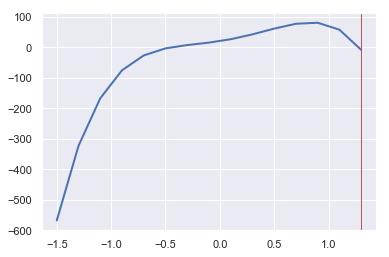

In [6]:
f = lambda x: -100*pow(x,4) + 39*pow(x,3) + 59*pow(x,2) + 55*x + 20

x = np.arange(-1.5,1.5,(10 - (-10))/100)
y = f(x)

%matplotlib inline
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2, markersize=12)
ax.axvline(x=1.30,linewidth=1, color='r')

It becomes clear the the solution to this problem, 
is one where x is a real number such that $f(x) = 0$.

This may seem trivial but it highlights what irr is essentially doing from a mathetical perspective. This means in order to solve for $r$ we need to be able to find the roots of a polynomial equation.

This is known as [Root Finding](https://en.wikipedia.org/wiki/Root-finding_algorithm)

### Numpy root finding

You can see numpy's root function, which uses the eigenvalue approach to solve the roots:

* https://github.com/numpy/numpy/blob/v1.9.1/numpy/lib/polynomial.py#L151

* http://web.mit.edu/18.06/www/Spring17/Eigenvalue-Polynomials.pdf

## The Financial Perspective

I just wanted to quickly touch on the below points before moving onto the method one can use to solve for IRR with scipy.

When solving for IRR we are essentially solving for a rate (yield for the FI traders) that solves for a **Net Present Value** (NPV) of zero.

Essentially, the rate that discounts all future cashflows (ins / outs) so that they equate to the amount originally invested.

As an example for a bond, IRR is essentially your yield to maturity at time of purchase... 

## A look at Scipy

Scipy has multiple `root finding` functions. See the below link for all the various options. I take a look @newton_krylov (the math is intense but apparently it's good for large sized polynomials).

* https://docs.scipy.org/doc/scipy-0.14.0/reference/optimize.html#root-finding

Remember being able to find the root of a polynomial is crucial for finding IRR, as this is essentially solving for `x` where the $NPV = 0$

In [7]:
from scipy.optimize import newton_krylov

g = lambda x: x**3 - x**2 + x + 40

print("Root of Function:")
print("-----------------")
print(newton_krylov(g, 2.0))

Root of Function:
-----------------
-3.0291609295472766


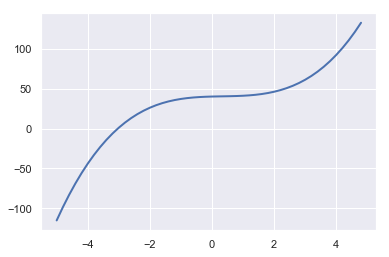

In [8]:
## VISUALIZING ABOVE FUNCTION

x = np.arange(-5,5,(10 - (-10))/100)
y = g(x)

%matplotlib inline
fig, ax = plt.subplots()
ax.plot(x, y, linewidth=2, markersize=12)

### Fsolve 

Using scipy fsolve to determine for which values of irr the npv = 0.

fsolve is scipy's function for *root finding* (non-linear functions).

https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.optimize.fsolve.html

Implementation take from: https://stackoverflow.com/questions/46203735/calculating-variable-cash-flow-irr-in-python-pandas

In [9]:
from scipy.optimize import fsolve

def npv(irr, cfs, yrs):  
    return np.sum(cfs / (1. + irr) ** yrs)

def irr(cfs, yrs, x0, **kwargs):
    return np.asscalar(fsolve(npv, x0=x0, args=(cfs, yrs), **kwargs))

In [10]:
cash_flow = np.array([-100.0, 39.0, 59.0, 55.0, 20.0])    
years_ago = np.array([0.0, 1.0, 2.0, 3.0, 4.0])

In [11]:
irr(cash_flow, years_ago, x0=0.3, maxfev=10000)

0.28094842115996105

### As proof lets confirm the above result with numpy

In [12]:
np.irr(cash_flow)

0.28094842115996066

# Optimising Using Numba

Literally this whole notebook is 
so I can claim numpy irr is slow and unstable while scipy is not
entirely optimised.

This claim is not entirely true. However, I really wanted to try [NUMBA](http://numba.pydata.org/numba-doc/latest/index.html) on something cool.

Basically I am probably wasting a bit of time but it's a good excuse to brush up on linear algebra and use `NUMBA` :)

In [13]:
## import numba jit and setup kwargs
from numba import jit

kwargs = {"nopython" : True, "error_model" : 'numpy'}

Using Newtons Method - function basically taken from the below 
really clean piece of code:
https://www.math.ubc.ca/~pwalls/math-python/roots-optimization/newton/

In [14]:
@jit(**kwargs)
def eval_polynomial(P, x):
    '''
    Compute polynomial P(x) where P is a vector of coefficients, highest
    order coefficient at P[0].  Uses Horner's Method.
    '''
    result = 0
    for coeff in P:
        result = x * result + coeff
    return result

In [15]:
@jit(**kwargs)
def newton(f, Df, x0, epsilon=1e-9, max_iter=1e9):
    '''Approximate solution of f(x)=0 by Newton's method.

    Parameters
    ----------
    f : list
        Function for which we are searching for a solution f(x)=0.
    Df : list
        Derivative of f(x).
    x0 : number
        Initial guess for a solution f(x)=0.
    epsilon : number
        Stopping criteria is abs(f(x)) < epsilon.
    max_iter : integer
        Maximum number of iterations of Newton's method.

    Returns
    -------
    xn : number
        Implement Newton's method: compute the linear approximation
        of f(x) at xn and find x intercept by the formula
            x = xn - f(xn)/Df(xn)
        Continue until abs(f(xn)) < epsilon and return xn.
        If Df(xn) == 0, return None. If the number of iterations
        exceeds max_iter, then return None.

    '''
    xn = x0
    for n in range(0,max_iter):
        print(xn)
        fxn = eval_polynomial(f,xn)
        if abs(fxn) < epsilon:
            print('Found solution after',n,'iterations.')
            return xn
        Dfxn = eval_polynomial(Df,xn)
        if Dfxn == 0:
            print('Zero derivative. No solution found.')
            return None
        xn = xn - fxn/Dfxn
    print('Exceeded maximum iterations. No solution found.')
    return None

In [16]:
import numpy.core.numeric as NX

@jit(**kwargs)
def calculate_polynomial_derivative(p):
    """
    https://stackoverflow.com/questions/18093509/how-can-i-create-functions-that-handle-polynomials
    
    """
    p = NX.asarray(p)
    n = len(p) - 1
    y = p[:-1] * NX.arange(n, 0, -1)
    return y

In [17]:
@jit(**kwargs)
def calculate_irr(cf, r0):
    """
    Calculate the internal rate of return (irr)
    of an investment per period provided.
    
    Args:
    ------
        cf (numpy.array): The array of cash flows
        r0 (int): The estimate of the irr (note not x)
        
    Returns:
    --------
        float: The calculated irr over the life of the investment
        per period.
    
    """
    
    ## Reverse order of array as cashflows are from start to finish.
    #cf = cf[::-1]
    ## Get the derivative of the polynomial
    dcf = calculate_polynomial_derivative(cf)
    root = newton(cf, dcf, 1 + r0)
    
    if root is not None:
        irr = root - 1
    else:
        irr = None
    
    return irr

In [18]:
cfs = [-100.0, 39.0, 59.0, 55.0, 20.0]
calculate_irr(cfs, .3)

1.3
1.2815579579833711
1.2809490713476943
1.2809484211607018
Found solution after 3 iterations.


0.28094842116070184

The above is a slightly disappointing result, fairly slower than scipy / numpy

## fastats library

Cool library using `numba` a lot more effectively than me!

In [30]:
# px doesn't work with fastats at the moment 
# TODO: Look at solving this 
def px(x):
#     res = x**3 - x - 1
    res = eval_polynomial(cfs, x)
    return res

def f(x):
    return x**3 - 4

In [31]:
from fastats import newton_raphson

In [32]:
newton_raphson(0.025, 1e-6, root=f)

1.5874010519682042